## Processing of search results ##

## Import data from OVH server

In [7]:
import json
import ipywidgets as widgets
from dotenv import load_dotenv
from IPython.display import display
import os
import subprocess

def import_file(b):
    load_dotenv()
    
    # Define a variable based on a value from .env
    server = os.getenv("server")
    username=os.getenv("username")
    remote_host=username+"@"+server
          
    remote_path = "/home/codechallenge/InnoClass/backend/classEngine/data/"
    #password = getpass.getpass(f"Enter password for {remote_host}: ")
    #command = ["scp", "-o", f"StrictHostKeyChecking=no", "-o", f"PreferredAuthentications=password", filename, f"{remote_host}:{remote_path}"]
    command = ["scp", f"{remote_host}:{remote_path}"+"search_results.json","."]
    try:
            print("command 1 : ")
            process = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            stdout, stderr = process.communicate() # Append newline to password
            return_code = process.returncode
            if return_code == 0:
                print("SCP command executed successfully.")
                print("Output:", stdout)
            else:
                print(f"SCP command failed with error (code {return_code}):")
                print("Error!:", stderr)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

select_button = widgets.Button(description="Import result file")
select_button.on_click(import_file)
display(select_button)

Button(description='Import result file', style=ButtonStyle())

## Processing data

In [3]:
def save_dataframe(df,filename):
    with open(filename, 'wb') as f:
        pickle.dump(df, f)

In [7]:
def read_dataframe(filepath):
    try:
        with open(filepath, 'rb') as f:
            df = pickle.load(f)
        print("sdgs read")
        if isinstance(df, pd.DataFrame):
            return df
        else:
            print(f"Error: Pickle file does not contain a pandas DataFrame.")
            return None
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return None
    except Exception as e:
        print(f"Error reading dataframe: {e}")
        return None

In [26]:
import pandas as pd
import json
import pickle

# 1. Load the JSON file "search_results.json"
with open("search_results.json", "r") as file:
    json_data = json.load(file)

# 2. Build a list of records by iterating over each id_target and flattening the nested "original_data" dictionary.
records = []
for id_target, entries in json_data.items():
    for entry in entries:
        record = {
            "id_target": id_target,
            "id": entry["original_data"]["id"],
            "score": entry["score"],
            "sentence": entry["original_data"]["sentence"]
        }
        records.append(record)

# Create a DataFrame from the records list.
df = pd.DataFrame(records)
#save_dataframe(df,'search_results.dat')
sdg_targets=read_dataframe('sgd_targets.dat')
sdg_targets["id_target"]=sdg_targets["Target ID"]
df2=df.merge(sdg_targets[['id_target', 'Target Text']], on='id_target', how='left')
df2["classification"]= ""

sdgs read


In [27]:
df2

,id_target,id,score,sentence,Target Text,classification
0,1.1,EP3103874A920181107,0.613108,"It is of increasing commercial interest, parti...",Eradicate extreme poverty for all people every...,
1,1.1,EP2852293B920160928,0.603634,"However, a further reduction of the feed conve...",Eradicate extreme poverty for all people every...,
2,1.1,EP4062942A120220928,0.573582,"https://doi.org/10.1021/ja205081s; Butora, G.",Eradicate extreme poverty for all people every...,
3,1.1,EP2852293B920160928,0.573517,The present invention relates to a method for ...,Eradicate extreme poverty for all people every...,
4,1.1,EP2852293B920160928,0.570637,A high-calorie feed enables to achieve a lower...,Eradicate extreme poverty for all people every...,
...,...,...,...,...,...,...
1655,17.19,EP1633865B120110928,0.566060,A similar principle for the generation of a di...,build on existing initiatives to develop measu...,
1656,17.19,EP2852293B920160928,0.565588,Much emphasis is put on the bodyweight gain of...,build on existing initiatives to develop measu...,
1657,17.19,EP3103874A920181107,0.564352,"During the reaction, fructose derived from the...",build on existing initiatives to develop measu...,
1658,17.19,EP4062942A120220928,0.564215,"In this field, a significant challenge for che...",build on existing initiatives to develop measu...,


In [33]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# --- Persistent State Dictionary ---
# Use a dictionary to remember the validated state of each (id, sentence) pair.
# Key: (id, sentence), Value: Boolean (True for valid, False for not valid).
validation_state = {}

# --- Widget Setup ---
# Create a dropdown widget listing the unique prompts.
unique_prompts = df['Target Text'].unique()
prompt_dropdown = widgets.Dropdown(
    options=unique_prompts,
    description='Prompt:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# An output widget to display the search results and validation controls.
output_area = widgets.Output()

# --- Checkbox Change Handler ---
def checkbox_handler(change, key):
    if change['name'] == 'value':
        # Update the persistent state based on the checkbox toggle.
        validation_state[key] = change['new']

# --- Render Function ---
def render_results_for_prompt(prompt):
    # Filter the DataFrame for the selected prompt.
    filtered_df = df[df['Target Text'] == prompt]
    
    # We'll compile widgets for each search result.
    result_widgets = []
    for _, row in filtered_df.iterrows():
        # Define a unique key for persistence using the id and sentence.
        key = (row['id'], row['sentence'])
        
        # Create display widgets for the sentence, score, and original full text.
        sentence_label = widgets.HTML(value=f"<b>Sentence:</b> {row['sentence']}")
        score_label = widgets.HTML(value=f"<b>Score:</b> {row['score']}")
        original_text_label = widgets.HTML(value=f"<b>Original Text:</b> {id_to_text.get(row['id'], 'Not found')}")
        
        # Set initial checkbox value based on the persistent state.
        initial_value = validation_state.get(key, False)
        valid_checkbox = widgets.Checkbox(
            value=initial_value,
            description='Mark as Valid'
        )
        
        # Attach an observer to update the state when the checkbox changes.
        valid_checkbox.observe(lambda change, key=key: checkbox_handler(change, key), names='value')
        
        # Group these widgets into a vertical layout.
        row_widget = widgets.VBox([sentence_label, score_label, original_text_label, valid_checkbox, widgets.HTML(value="<hr>")])
        result_widgets.append(row_widget)
    
    return widgets.VBox(result_widgets)

# --- Dropdown Change Handler ---
def handle_prompt_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_prompt = change['new']
        with output_area:
            clear_output()
            results_widget = render_results_for_prompt(selected_prompt)
            display(results_widget)

# Observe changes on the prompt selection.
prompt_dropdown.observe(handle_prompt_change, names='value')

# Display the dropdown and output widgets in your notebook.
display(prompt_dropdown, output_area)



Dropdown(description='Prompt:', layout=Layout(width='50%'), options=('Eradicate extreme poverty for all people…

Output()

In [13]:
# 3. Define a helper function to merge sentences (concatenate with a space).
def merge_sentences(sentences):
    return " ".join(sentences)

# 4. Group by 'id_target' and 'id'
#    - For score, take the maximum value in each group.
#    - For sentence, merge (concatenate) all sentence strings.
grouped_df = df.groupby(["id_target", "id"], as_index=False).agg(
    ascore=("score", "max"),
    sentence=("sentence", merge_sentences)
)

print("\nGrouped DataFrame:")
print(grouped_df)


Original DataFrame:
     id_target                   id     score  \
0          1.1  EP3103874A920181107  0.613108   
1          1.1  EP2852293B920160928  0.603634   
2          1.1  EP4062942A120220928  0.573582   
3          1.1  EP2852293B920160928  0.573517   
4          1.1  EP2852293B920160928  0.570637   
...        ...                  ...       ...   
1655     17.19  EP1633865B120110928  0.566060   
1656     17.19  EP2852293B920160928  0.565588   
1657     17.19  EP3103874A920181107  0.564352   
1658     17.19  EP4062942A120220928  0.564215   
1659     17.19  EP4062942A120220928  0.560558   

                                               sentence  
0     It is of increasing commercial interest, parti...  
1     However, a further reduction of the feed conve...  
2         https://doi.org/10.1021/ja205081s; Butora, G.  
3     The present invention relates to a method for ...  
4     A high-calorie feed enables to achieve a lower...  
...                                        

In [44]:
grouped_df["sentence"][0]

"The clutch is actuated by a spring which is set according to individual ' requirements."

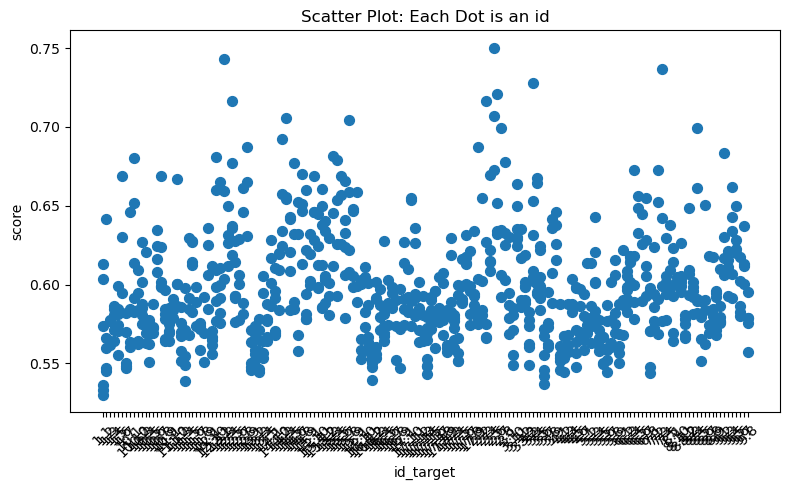

In [17]:
import matplotlib.pyplot as plt

# Convert id_target to a categorical type and add a numerical code column
df=grouped_df
df['id_target_cat'] = df['id_target'].astype('category')
df['id_target_code'] = df['id_target_cat'].cat.codes

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(df['id_target_code'], df['ascore'], s=50)  # s sets the marker size

# Set x-axis ticks and labels back to the original id_target values.
# Note: We get the categories in sorted order.
categories = df['id_target_cat'].cat.categories
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45)

# Labeling the axes
ax.set_xlabel('id_target')
ax.set_ylabel('score')
ax.set_title('Scatter Plot: Each Dot is an id')

plt.tight_layout()
plt.show()

In [18]:
df['id'].nunique()

10

In [36]:
targets_dataframe=read_dataframe("sgd_targets.dat")
df["target"]=targets_dataframe["Target Text"]

sdgs read


In [40]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import pickle


# Ensure there is a column for validation responses.
df['validation'] = ""

# Get unique targets based on 'id_target'
targets = df['id_target'].unique()
current_index = 0  # This will track which target is being shown

# Create a read-only Textarea widget to display the target description.
text_area = widgets.Textarea(
    value=df[df['id_target'] == targets[current_index]]['target'].iloc[0],
    layout=widgets.Layout(width='100%', height='100px'),
    disabled=True
)

# Navigation buttons.
prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")

# Box to hold the grid rows.
grid_box = widgets.VBox()

def update_text_area():
    """Update the textarea with the target description for the current target."""
    current_target = targets[current_index]
    text_value = df[df['id_target'] == current_target]['target'].iloc[0]
    text_area.value = text_value

def update_grid():
    """Update the grid below based on the current target.
    It filters and sorts the rows, then creates a row widget for each row with id, sentence,
    score, and a dropdown for validation.
    """
    current_target = targets[current_index]
    # Filter for current target and sort rows by score (highest first)
    df_target = df[df['id_target'] == current_target].sort_values(by='ascore', ascending=False)
    row_widgets = []
    
    for idx, row in df_target.iterrows():
        # Dropdown for validation with preset choices; if a value has been set, use it.
        dd = widgets.Dropdown(
            options=["OK", "NOT OK", "UNSURE"],
            value=row['validation'] if row['validation'] in ["OK", "NOT OK", "UNSURE"] else None
        )
        
        # Make sure the correct row is updated by capturing the current idx.
        def on_change(change, idx=idx):
            if change['name'] == 'value' and change['new'] is not None:
                df.loc[idx, 'validation'] = change['new']
        
        dd.observe(on_change, names='value')
        
        # Create labels for the id, sentence, and score.
        id_label = widgets.Label(value=row['id'], layout=widgets.Layout(width='10%'))
        sentence_area = widgets.Textarea(
            value=row['sentence'],
            layout=widgets.Layout(width='60%', height='auto', overflow='auto'),
            disabled=True
        )
        score_label = widgets.Label(value=f"{row['ascore']:.2f}", layout=widgets.Layout(width='10%'))
        dropdown_container = widgets.HBox([dd], layout=widgets.Layout(width='20%'))
        
        # Combine row components into a horizontal box.
        row_widget = widgets.HBox([id_label, sentence_area, score_label, dropdown_container])
        row_widgets.append(row_widget)
    
    grid_box.children = row_widgets

def on_prev(b):
    """Navigate to the previous target if available."""
    global current_index
    if current_index > 0:
        current_index -= 1
        update_text_area()
        update_grid()

def on_next(b):
    """Navigate to the next target if available."""
    global current_index
    if current_index < len(targets) - 1:
        current_index += 1
        update_text_area()
        update_grid()

prev_button.on_click(on_prev)
next_button.on_click(on_next)

# Save Button to write the dataframe to a pickle file.
save_button = widgets.Button(description="Save Results")
def on_save(b):
    with open("dataframe_results.dat", "wb") as f:
        pickle.dump(df, f)
    print("Dataframe saved as dataframe_results.dat")
save_button.on_click(on_save)

# Initialize grid with data corresponding to the first target.
update_grid()

# Arrange all components vertically.
ui = widgets.VBox([
    text_area,
    widgets.HBox([prev_button, next_button]),
    grid_box,
    save_button
])

# Display the complete widget interface in the notebook.
display(ui)
